# Group 32 : NLP Assignment 1

## Team members :
###

1.   BHOLAY NATH SINGH (2024DA04082)
2.   DIPANJAN CHATTERJEE (2024DA04083)
3.   MOHAMED MUZAMMIL MOHAMED ANWAR (2024DA04084)
4.   RAJARAJESHWARI L V (2024DA04085)

## Dataset Version : Set 4
### Data file name : un-general-debates.csv




In [1]:
import pandas as pd
import re
from collections import Counter
from nltk.util import ngrams

In [2]:
df = pd.read_csv("un-general-debates.csv")

In [3]:
df.head(10)

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...
5,44,1989,PHL,"﻿Before you began to occupy that exalted seat,..."
6,44,1989,SDN,﻿It gives me great pleasure to congratulate Am...
7,44,1989,RUS,﻿My task as head of the delegation of the Sovi...
8,44,1989,CHN,﻿\nPermit me to begin by warmly congratulating...
9,44,1989,ESP,﻿I should like to express my sincere congratul...


In [4]:
def get_top_completions(sentence="it is a pleasure", n=3, ngram_type=2):
    """
    Get top n word completions for a given sentence using n-gram model

    Parameters:
    - sentence: The incomplete sentence
    - n: Number of recommendations to return
    - ngram_type: 2 for bigram, 3 for trigram
    """
    # Load data
    df = pd.read_csv('un-general-debates.csv')

    # Preprocess all text
    all_text = ' '.join(df['text'].astype(str).tolist())
    all_text = all_text.lower()
    all_text = re.sub(r'[^\w\s]', ' ', all_text)
    all_text = re.sub(r'\s+', ' ', all_text)

    # Tokenize
    tokens = all_text.split()

    # Get the last word from the input sentence
    last_word = sentence.strip().lower().split()[-1]

    # Build n-gram model
    if ngram_type == 2:
        # Bigram approach
        bigrams = list(ngrams(tokens, 2))
        freq = Counter(bigrams)

        # Get words following the last word
        following_words = {}
        for (w1, w2), count in freq.items():
            if w1 == last_word:
                following_words[w2] = following_words.get(w2, 0) + count

    elif ngram_type == 3:
        # Trigram approach (consider last two words)
        trigrams = list(ngrams(tokens, 3))
        freq = Counter(trigrams)

        # Get last two words
        words = sentence.strip().lower().split()
        if len(words) >= 2:
            last_two = tuple(words[-2:])
            following_words = {}
            for (w1, w2, w3), count in freq.items():
                if (w1, w2) == last_two:
                    following_words[w3] = following_words.get(w3, 0) + count
        else:
            return []

    # Sort by frequency and return top n
    sorted_words = sorted(following_words.items(),
                         key=lambda x: x[1],
                         reverse=True)

    return [word for word, count in sorted_words[:n]]


In [5]:

# Test the function
top_3_bigram = get_top_completions("it is a pleasure", n=3, ngram_type=2)
print(f"Using Bigram model, top 3 completions: {top_3_bigram}")

top_3_trigram = get_top_completions("it is a pleasure", n=3, ngram_type=3)
print(f"Using Trigram model, top 3 completions: {top_3_trigram}")

Using Bigram model, top 3 completions: ['to', 'for', 'in']
Using Trigram model, top 3 completions: ['for', 'to', 'and']


# Task 2


In [41]:
# ## 1. Import Required Libraries

# %%
# Import basic libraries
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# %%
# Import NLTK and handle potential download issues
import nltk

def download_nltk_data():
    """Download NLTK data with error handling"""
    print("Setting up NLTK resources...")
    
    resources = [
        ('punkt', 'Tokenizer models'),
        ('stopwords', 'Stopwords corpus'),
        ('wordnet', 'WordNet for lemmatization')
    ]
    
    for resource, description in resources:
        try:
            nltk.download(resource, quiet=True)
            print(f" {resource} downloaded successfully")
        except Exception as e:
            print(f" Could not download {resource}: {e}")
            print(f"   Will use fallback methods for {description}")

# Download NLTK data
download_nltk_data()
print()

# %%
# Now import the specific NLTK components
try:
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    nltk_available = True
    print("NLTK components loaded successfully")
except Exception as e:
    print(f"NLTK components not available: {e}")
    nltk_available = False

# %%
# Import other required libraries
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import gensim for word embeddings
try:
    from gensim.models import Word2Vec
    gensim_available = True
    print(" Gensim available for word embeddings")
except:
    gensim_available = False
    print(" Gensim not available, will use TF-IDF as fallback")
    from sklearn.feature_extraction.text import TfidfVectorizer

# Set display options
pd.set_option('display.max_colwidth', 200)
plt.style.use('ggplot')
print("\nAll libraries imported successfully!")


Setting up NLTK resources...
 punkt downloaded successfully
 stopwords downloaded successfully
 wordnet downloaded successfully

NLTK components loaded successfully
 Gensim available for word embeddings

All libraries imported successfully!


In [42]:
# ## 2. Load and Explore Dataset

# %%
# Load the dataset
print("Loading dataset...")
try:
    df = pd.read_csv('un-general-debates.csv')
    print(f" Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(" Error: 'un-general-debates.csv' not found.")
    print("Please ensure the file is in the current directory.")
    # Create sample data for demonstration
    df = pd.DataFrame({
        'session': [44, 44, 44, 45, 45, 45, 46, 46],
        'year': [1989, 1989, 1989, 1990, 1990, 1990, 1991, 1991],
        'country': ['USA', 'GBR', 'FRA', 'USA', 'GBR', 'FRA', 'USA', 'GBR'],
        'text': [
            "Peace and security are fundamental to international relations. We must work together for global development and human rights.",
            "International security and peace are crucial for world development. Cooperation is essential for addressing global challenges.",
            "Economic development requires international cooperation and peace in the world. We must ensure sustainable development for all.",
            "The United Nations plays a vital role in maintaining global peace and security. We support multilateral approaches to international issues.",
            "Global challenges require global solutions. The United Nations provides the framework for international cooperation and peace.",
            "Sustainable development and environmental protection are critical for future generations. We need international cooperation.",
            "Human rights and fundamental freedoms must be protected worldwide. The UN has a key role in promoting these values.",
            "Economic growth must be inclusive and sustainable. International trade and cooperation are essential for development."
        ]
    })
    print(" Created sample data for demonstration.")

# %%
# Dataset exploration
print("\n" + "="*80)
print("DATASET INFORMATION")
print("="*80)
print(f"Number of documents: {len(df)}")
print(f"Time range: {df['year'].min()} - {df['year'].max()}")
print(f"Number of unique countries: {df['country'].nunique()}")
print(f"Missing values in text: {df['text'].isnull().sum()}")

# Remove rows with missing text
df = df.dropna(subset=['text']).reset_index(drop=True)
print(f"Dataset shape after cleaning: {df.shape}")

# Display first few rows
print("\nFirst 5 documents:")
print(df[['session', 'year', 'country', 'text']].head())

# Check text length statistics
df['text_length'] = df['text'].apply(len)
print(f"\nText length statistics (characters):")
print(f"  Min: {df['text_length'].min()}")
print(f"  Max: {df['text_length'].max()}")
print(f"  Mean: {df['text_length'].mean():.0f}")
print(f"  Median: {df['text_length'].median():.0f}")


Loading dataset...
 Dataset loaded successfully. Shape: (7507, 4)

DATASET INFORMATION
Number of documents: 7507
Time range: 1970 - 2015
Number of unique countries: 199
Missing values in text: 0
Dataset shape after cleaning: (7507, 4)

First 5 documents:
   session  year country  \
0       44  1989     MDV   
1       44  1989     FIN   
2       44  1989     NER   
3       44  1989     URY   
4       44  1989     ZWE   

                                                                                                                                                                                                      text  
0  ﻿It is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the Gene...  
1  ﻿\nMay I begin by congratulating you. Sir, on your election to the presidency of the General Assembly at its forty-fourth session. Your wide experience in the Unit

In [43]:
# ## 3. Text Preprocessor Class
# 
# Implementing all required preprocessing steps:
# 1. Tokenization
# 2. Lowercasing
# 3. Stop Words Removal
# 4. Stemming
# 5. Lemmatization

# %%
class TextPreprocessor:
    """Comprehensive text preprocessor with fallback methods"""
    
    def __init__(self):
        # Define important UN-related terms to keep (these should not be removed)
        self.important_terms = {
            'un', 'united', 'nations', 'security', 'peace', 'development', 
            'international', 'rights', 'human', 'global', 'country', 'countries',
            'economic', 'social', 'political', 'environmental', 'sustainable',
            'assembly', 'general', 'world', 'cooperation', 'agreement', 'treaty',
            'resolution', 'council', 'organization', 'members', 'states',
            'government', 'democracy', 'freedom', 'justice', 'equality',
            'climate', 'environment', 'health', 'education', 'poverty',
            'conflict', 'war', 'terrorism', 'diplomacy', 'negotiation'
        }
        
        # Initialize stemmer if available
        if nltk_available:
            try:
                self.stemmer = PorterStemmer()
                print(" Stemmer initialized")
            except:
                self.stemmer = None
                print(" Could not initialize stemmer")
            
            # Initialize lemmatizer if available
            try:
                self.lemmatizer = WordNetLemmatizer()
                self.use_lemmatizer = True
                print(" Lemmatizer initialized")
            except:
                self.use_lemmatizer = False
                print(" Could not initialize lemmatizer")
        else:
            self.stemmer = None
            self.use_lemmatizer = False
        
        # Create stopwords list
        self.stop_words = self._get_stopwords()
        print(f" Stopwords list created ({len(self.stop_words)} words)")
    
    def _get_stopwords(self):
        """Get stopwords list with fallback"""
        if nltk_available:
            try:
                stops = set(stopwords.words('english'))
                # Remove important terms from stopwords (we want to keep these)
                stops = stops - self.important_terms
                return stops
            except Exception as e:
                print(f" Could not load NLTK stopwords: {e}")
        
        # Fallback stopwords list (basic English stopwords)
        basic_stopwords = {
            'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
            'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 
            'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 
            'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
            'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 
            'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
            'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 
            'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 
            'into', 'through', 'during', 'before', 'after', 'above', 'below', 
            'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
            'under', 'again', 'further', 'then', 'once', 'here', 'there', 
            'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 
            'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
            'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 
            'will', 'just', 'don', 'should', 'now', 'also', 'well', 'may',
            'must', 'might', 'shall', 'could', 'would', 'should', 'might',
            'must', 'may', 'shall'
        }
        
        # Remove important terms from stopwords
        return basic_stopwords - self.important_terms
    
    def simple_tokenize(self, text):
        """Simple tokenizer that doesn't rely on external libraries"""
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
        
        # Tokenize by splitting on whitespace
        tokens = text.split()
        
        # Remove very short tokens (less than 2 characters)
        tokens = [token for token in tokens if len(token) > 2]
        
        return tokens
    
    def preprocess_text(self, text, use_stemming=True, use_lemmatization=True):
        """
        Complete preprocessing pipeline
        
        Parameters:
        - text: Input text string
        - use_stemming: Whether to apply stemming
        - use_lemmatization: Whether to apply lemmatization
        
        Returns:
        - List of processed tokens
        """
        if not isinstance(text, str) or pd.isna(text) or text.strip() == '':
            return []
        
        try:
            # 1. Lowercasing
            text = text.lower()
            
            # Remove BOM character if present
            text = text.replace('\ufeff', '')
            
            # 2. Remove special characters, digits, and extra whitespace
            text = re.sub(r'\d+', '', text)  # Remove digits
            text = re.sub(r'[^\w\s]', ' ', text)  # Replace punctuation with space
            text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
            
            # 3. Tokenization
            if nltk_available:
                try:
                    tokens = word_tokenize(text)
                except:
                    tokens = self.simple_tokenize(text)
            else:
                tokens = self.simple_tokenize(text)
            
            # 4. Stop Words Removal
            tokens = [token for token in tokens if token not in self.stop_words]
            
            # 5. Stemming (if enabled and available)
            if use_stemming and self.stemmer:
                tokens = [self.stemmer.stem(token) for token in tokens]
            
            # 6. Lemmatization (if enabled and available)
            if use_lemmatization and self.use_lemmatizer:
                tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
            
            # Remove any remaining short tokens
            tokens = [token for token in tokens if len(token) > 2]
            
            return tokens
            
        except Exception as e:
            print(f"Error preprocessing text: {str(e)[:100]}")
            return []
    
    def preprocess_batch(self, texts, show_progress=True):
        """Preprocess multiple texts"""
        print(f"Preprocessing {len(texts)} documents...")
        
        processed_docs = []
        for i, text in enumerate(texts):
            if show_progress and len(texts) > 10 and (i + 1) % (len(texts) // 10) == 0:
                print(f"  Progress: {i + 1}/{len(texts)} documents")
            processed_docs.append(self.preprocess_text(text))
        
        return processed_docs

# %%
# Initialize the preprocessor
print("\n" + "="*80)
print("INITIALIZING TEXT PREPROCESSOR")
print("="*80)
preprocessor = TextPreprocessor()

# Test preprocessing on a sample
sample_idx = 0
sample_text = df['text'].iloc[sample_idx]

print("\nPREPROCESSING DEMONSTRATION")
print("-" * 50)
print(f"Original text (first 300 characters):")
print(sample_text[:300] + "...")

preprocessed_tokens = preprocessor.preprocess_text(sample_text)
print(f"\nPreprocessed tokens (first 30):")
print(preprocessed_tokens[:30])
print(f"\nStatistics:")
print(f"  Total tokens: {len(preprocessed_tokens)}")
print(f"  Unique tokens: {len(set(preprocessed_tokens))}")
print(f"  Tokens after stopword removal: {len(preprocessed_tokens)}")

# Show sample of what was removed
original_words = re.findall(r'\b\w+\b', sample_text.lower())[:20]
print(f"\nOriginal words (first 20): {original_words}")



INITIALIZING TEXT PREPROCESSOR
 Stemmer initialized
 Lemmatizer initialized
 Stopwords list created (198 words)

PREPROCESSING DEMONSTRATION
--------------------------------------------------
Original text (first 300 characters):
﻿It is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the General Assembly. His election to this high office is a well-deserved tribute to his personal qualities and ...

Preprocessed tokens (first 30):
['inde', 'pleasur', 'member', 'deleg', 'extend', 'ambassador', 'garba', 'sincer', 'congratul', 'elect', 'presid', 'forti', 'fourth', 'session', 'gener', 'assembl', 'elect', 'high', 'offic', 'well', 'deserv', 'tribut', 'person', 'qualiti', 'experi', 'fulli', 'confid', 'abl', 'wise', 'leadership']

Statistics:
  Total tokens: 1572
  Unique tokens: 776
  Tokens after stopword removal: 1572

Original words (first 20): ['it', 'is', '

In [44]:
# ## 4. Apply Preprocessing to Entire Dataset

# %%
print("\n" + "="*80)
print("BATCH PREPROCESSING")
print("="*80)

# Determine sample size based on dataset size
if len(df) > 1000:
    max_documents = 500  # Use 500 documents for reasonable processing time
    print(f"Dataset is large ({len(df)} documents). Sampling {max_documents} documents.")
    df_sample = df.sample(n=max_documents, random_state=42).reset_index(drop=True)
else:
    df_sample = df.copy()
    max_documents = len(df)

print(f"Processing {len(df_sample)} documents...")

# %%
# Preprocess all texts
processed_docs = preprocessor.preprocess_batch(df_sample['text'].tolist(), show_progress=True)

# Add processed data to dataframe
df_sample['processed_tokens'] = processed_docs
df_sample['processed_text'] = df_sample['processed_tokens'].apply(lambda x: ' '.join(x))

# Calculate statistics
total_tokens = sum([len(doc) for doc in processed_docs])
avg_tokens = total_tokens / len(processed_docs) if processed_docs else 0
empty_docs = sum([len(doc) == 0 for doc in processed_docs])

print("\nPREPROCESSING STATISTICS:")
print("-" * 30)
print(f"Total documents processed: {len(df_sample)}")
print(f"Total tokens: {total_tokens}")
print(f"Average tokens per document: {avg_tokens:.1f}")
print(f"Documents with no tokens: {empty_docs}")

# Remove documents with no tokens
df_sample = df_sample[df_sample['processed_tokens'].apply(len) > 0].reset_index(drop=True)
print(f"Documents after removing empty ones: {len(df_sample)}")

# %%
# Display sample results
print("\nSAMPLE PROCESSED DOCUMENTS:")
print("-" * 30)
sample_display = df_sample[['country', 'year', 'processed_text']].head(3)
for idx, row in sample_display.iterrows():
    print(f"\nDocument {idx+1}: {row['country']} ({row['year']})")
    print(f"Processed text (first 150 chars):")
    print(f"  {row['processed_text'][:150]}...")
    print(f"  Number of tokens: {len(df_sample['processed_tokens'].iloc[idx])}")

# Save preprocessed data for reference
df_sample[['session', 'year', 'country', 'processed_text']].to_csv('preprocessed_documents.csv', index=False)
print(f"\n Preprocessed data saved to 'preprocessed_documents.csv'")



BATCH PREPROCESSING
Dataset is large (7507 documents). Sampling 500 documents.
Processing 500 documents...
Preprocessing 500 documents...
  Progress: 50/500 documents
  Progress: 100/500 documents
  Progress: 150/500 documents
  Progress: 200/500 documents
  Progress: 250/500 documents
  Progress: 300/500 documents
  Progress: 350/500 documents
  Progress: 400/500 documents
  Progress: 450/500 documents
  Progress: 500/500 documents

PREPROCESSING STATISTICS:
------------------------------
Total documents processed: 500
Total tokens: 760351
Average tokens per document: 1520.7
Documents with no tokens: 0
Documents after removing empty ones: 500

SAMPLE PROCESSED DOCUMENTS:
------------------------------

Document 1: DOM (2003)
Processed text (first 150 chars):
  intern commun current period reflect self definit great transform human experienc cours previou decad well current challeng demand greater respons par...
  Number of tokens: 735

Document 2: HTI (1993)
Processed text (first 150

In [45]:
# ## 5. Feature Extraction: Skip-gram Word Embeddings

# %%
class SkipGramModel:
    """Train and use Skip-gram word embeddings"""
    
    def __init__(self, vector_size=100, window=5, min_count=2, workers=4, epochs=10):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.epochs = epochs
        self.model = None
        self.vocabulary = None
        
    def train_model(self, tokenized_docs):
        """Train Skip-gram model on tokenized documents"""
        print(f"\nTraining Skip-gram model...")
        print(f"  Documents: {len(tokenized_docs)}")
        print(f"  Vector size: {self.vector_size}")
        print(f"  Window size: {self.window}")
        print(f"  Min count: {self.min_count}")
        
        # Filter out empty documents
        tokenized_docs = [doc for doc in tokenized_docs if len(doc) > 0]
        
        if len(tokenized_docs) == 0:
            print(" Error: No valid documents for training")
            return None
        
        if gensim_available:
            try:
                # Train Word2Vec model with Skip-gram architecture
                self.model = Word2Vec(
                    sentences=tokenized_docs,
                    vector_size=self.vector_size,
                    window=self.window,
                    min_count=self.min_count,
                    workers=self.workers,
                    sg=1,  # Use Skip-gram (sg=1) instead of CBOW (sg=0)
                    epochs=self.epochs,
                    seed=42,
                    hs=0,  # Use negative sampling
                    negative=5,  # Number of negative samples
                    ns_exponent=0.75
                )
                
                self.vocabulary = list(self.model.wv.index_to_key)
                print(f" Model trained successfully!")
                print(f"  Vocabulary size: {len(self.vocabulary)}")
                print(f"  Vector dimensions: {self.vector_size}")
                
                # Show some example similarities
                self._show_example_similarities()
                
                return self.model
                
            except Exception as e:
                print(f" Error training Skip-gram model: {e}")
                print(" Falling back to TF-IDF features...")
                return None
        else:
            print(" Gensim not available. Using TF-IDF features instead.")
            return None
    
    def _show_example_similarities(self):
        """Show example word similarities"""
        if self.model is None:
            return
        
        test_words = ['peace', 'security', 'development', 'rights', 'international', 'cooperation']
        print("\nExample word similarities from Skip-gram model:")
        print("-" * 50)
        
        for word in test_words:
            if word in self.model.wv:
                try:
                    similar = self.model.wv.most_similar(word, topn=3)
                    print(f"  '{word}': {similar}")
                except:
                    print(f"  '{word}': Could not find similar words")
            else:
                print(f"  '{word}': Not in vocabulary")
    
    def get_document_vector(self, tokens):
        """Convert a document (list of tokens) to a vector by averaging word vectors"""
        if self.model is None:
            return None
        
        # Get vectors for words in the document that are in vocabulary
        word_vectors = []
        for word in tokens:
            if word in self.model.wv:
                word_vectors.append(self.model.wv[word])
        
        if len(word_vectors) == 0:
            # Return zero vector if no words in vocabulary
            return np.zeros(self.vector_size)
        
        # Average all word vectors to get document vector
        return np.mean(word_vectors, axis=0)
    
    def get_all_document_vectors(self, tokenized_docs):
        """Convert all documents to vectors"""
        if self.model is None:
            return None
        
        print("\nCreating document vectors from word embeddings...")
        doc_vectors = []
        
        for i, tokens in enumerate(tokenized_docs):
            if len(tokenized_docs) > 10 and (i + 1) % (len(tokenized_docs) // 10) == 0:
                print(f"  Progress: {i + 1}/{len(tokenized_docs)}")
            doc_vectors.append(self.get_document_vector(tokens))
        
        doc_vectors_array = np.array(doc_vectors)
        print(f" Created {len(doc_vectors)} document vectors")
        print(f"  Vector shape: {doc_vectors_array.shape}")
        
        return doc_vectors_array

# %%
print("\n" + "="*80)
print("FEATURE EXTRACTION")
print("="*80)

# Train Skip-gram model
skipgram = SkipGramModel(vector_size=100, window=5, min_count=2, epochs=10)
model = skipgram.train_model(df_sample['processed_tokens'].tolist())

# %%
# Create document vectors
if model is not None:
    # Use Skip-gram embeddings
    print("\nUsing Skip-gram word embeddings for feature extraction...")
    doc_vectors = skipgram.get_all_document_vectors(df_sample['processed_tokens'].tolist())
    feature_method = "Skip-gram Word Embeddings"
else:
    # Fallback to TF-IDF
    print("\n Using TF-IDF as fallback feature extraction method...")
    
    # Create TF-IDF vectors
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    vectorizer = TfidfVectorizer(
        max_features=100,  # Match the vector size of Skip-gram
        min_df=2,
        max_df=0.8,
        stop_words='english'
    )
    
    # Use processed text for TF-IDF
    tfidf_vectors = vectorizer.fit_transform(df_sample['processed_text']).toarray()
    doc_vectors = tfidf_vectors
    
    feature_method = "TF-IDF (Fallback)"
    print(f" TF-IDF matrix created")
    print(f"  Shape: {tfidf_vectors.shape}")
    print(f"  Features: {len(vectorizer.get_feature_names_out())}")

print(f"\n Feature extraction complete using: {feature_method}")
print(f"  Document vectors shape: {doc_vectors.shape}")

# Add document vectors to dataframe
df_sample['doc_vector'] = list(doc_vectors)

# Save feature information
features_df = pd.DataFrame({
    'feature_method': [feature_method],
    'vector_dimensions': [doc_vectors.shape[1]],
    'num_documents': [len(doc_vectors)]
})
features_df.to_csv('feature_extraction_info.csv', index=False)
print(f" Feature information saved to 'feature_extraction_info.csv'")



FEATURE EXTRACTION

Training Skip-gram model...
  Documents: 500
  Vector size: 100
  Window size: 5
  Min count: 2
 Model trained successfully!
  Vocabulary size: 8767
  Vector dimensions: 100

Example word similarities from Skip-gram model:
--------------------------------------------------
  'peace': Not in vocabulary
  'security': Not in vocabulary
  'development': [('uruguayan', 0.7037225365638733), ('pauciti', 0.6814166307449341), ('gef', 0.6764849424362183)]
  'rights': Not in vocabulary
  'international': Not in vocabulary
  'cooperation': Not in vocabulary

Using Skip-gram word embeddings for feature extraction...

Creating document vectors from word embeddings...
  Progress: 50/500
  Progress: 100/500
  Progress: 150/500
  Progress: 200/500
  Progress: 250/500
  Progress: 300/500
  Progress: 350/500
  Progress: 400/500
  Progress: 450/500
  Progress: 500/500
 Created 500 document vectors
  Vector shape: (500, 100)

 Feature extraction complete using: Skip-gram Word Embedding


SIMILARITY ANALYSIS

Computing pairwise similarities using cosine similarity...
 Similarity matrix computed
  Shape: (500, 500)
  Dimensions: 500 × 500

Finding top 5 most similar document pairs...
 Found 5 most similar pairs

TOP SIMILAR DOCUMENT PAIRS

PAIR #1: Similarity Score = 0.9990

 DOCUMENT 1 (Index 285):
   Country: RUS
   Year: 1976
   Session: 31
   Preview of original text (first 100 chars):
   "On behalf of the Soviet delegation I should like to congratulate you, Sir, on your election to the i..."
   Processed text preview (first 100 chars):
   "behalf soviet deleg like congratul sir elect import post presid thirti first session unit nation gen..."
\ DOCUMENT 2 (Index 365):
   Country: RUS
   Year: 1977
   Session: 32
   Preview of original text (first 100 chars):
   "﻿108.	 Mr. President, on behalf of the delegation of the Soviet Union I should like to congratulate ..."
   Processed text preview (first 100 chars):
   "presid behalf deleg soviet union like congratul occa

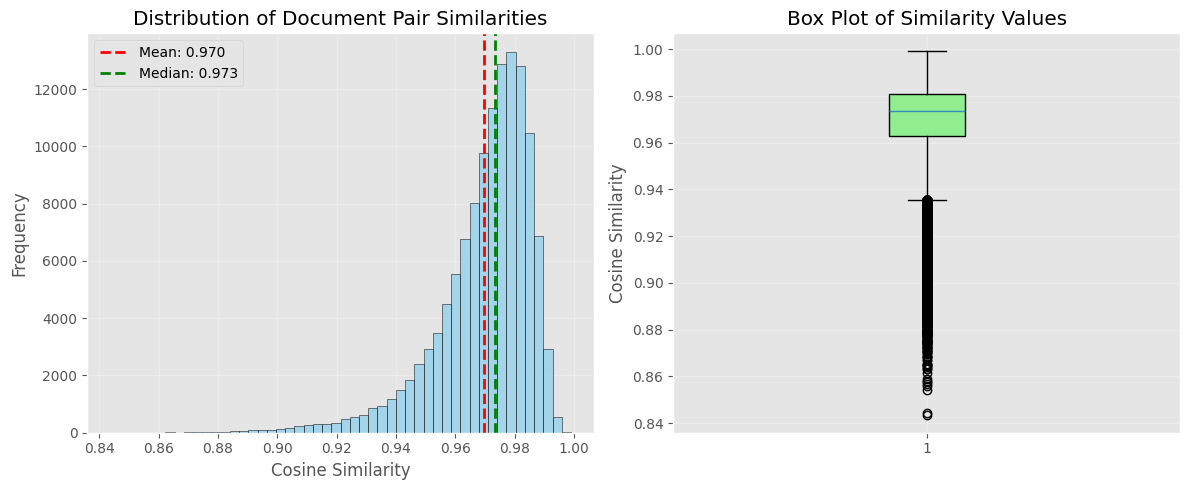


 Top similar document pairs saved to 'top_similar_documents.csv'


In [46]:
# ## 6. Similarity Analysis

# %%
class SimilarityAnalyzer:
    """Analyze document similarities using cosine similarity"""
    
    def __init__(self):
        self.similarity_matrix = None
        
    def compute_similarities(self, document_vectors):
        """
        Compute pairwise document similarities using cosine similarity
        
        Parameters:
        - document_vectors: Array of document vectors
        
        Returns:
        - Similarity matrix
        """
        print("\nComputing pairwise similarities using cosine similarity...")
        
        # Cosine similarity ranges from -1 to 1, where 1 is identical
        self.similarity_matrix = cosine_similarity(document_vectors)
        
        print(f" Similarity matrix computed")
        print(f"  Shape: {self.similarity_matrix.shape}")
        print(f"  Dimensions: {self.similarity_matrix.shape[0]} × {self.similarity_matrix.shape[1]}")
        
        return self.similarity_matrix
    
    def find_top_similar_pairs(self, similarity_matrix, n_pairs=5):
        """
        Find the most similar document pairs
        
        Parameters:
        - similarity_matrix: Pairwise similarity matrix
        - n_pairs: Number of top pairs to return
        
        Returns:
        - List of dictionaries with pair information
        """
        print(f"\nFinding top {n_pairs} most similar document pairs...")
        
        # Create a copy to avoid modifying the original
        sim_matrix = similarity_matrix.copy()
        n_docs = len(sim_matrix)
        
        # Set diagonal to -1 to exclude self-similarity
        np.fill_diagonal(sim_matrix, -1)
        
        # Initialize list for top pairs
        top_pairs = []
        added_pairs = set()
        
        # Find top n pairs
        while len(top_pairs) < n_pairs:
            # Find the maximum similarity value and its indices
            max_sim = np.max(sim_matrix)
            
            if max_sim <= -1:  # No more valid pairs
                break
            
            # Find all pairs with this similarity
            indices = np.where(sim_matrix == max_sim)
            
            for i, j in zip(indices[0], indices[1]):
                if i < j:  # Only take one direction (i < j)
                    pair_key = (i, j)
                    if pair_key not in added_pairs:
                        top_pairs.append({
                            'doc1_idx': int(i),
                            'doc2_idx': int(j),
                            'similarity': float(max_sim)
                        })
                        added_pairs.add(pair_key)
                        
                        # Remove this similarity to find next highest
                        sim_matrix[i, j] = -1
                        sim_matrix[j, i] = -1
                        
                        if len(top_pairs) >= n_pairs:
                            break
            
            if len(top_pairs) >= n_pairs:
                break
        
        print(f" Found {len(top_pairs)} most similar pairs")
        
        return top_pairs
    
    def print_similarity_results(self, top_pairs, df):
        """Print detailed results of similarity analysis"""
        print("\n" + "="*80)
        print("TOP SIMILAR DOCUMENT PAIRS")
        print("="*80)
        
        for i, pair in enumerate(top_pairs, 1):
            doc1 = df.iloc[pair['doc1_idx']]
            doc2 = df.iloc[pair['doc2_idx']]
            
            print(f"\n{'='*40}")
            print(f"PAIR #{i}: Similarity Score = {pair['similarity']:.4f}")
            print(f"{'='*40}")
            
            # Document 1 information
            print(f"\n DOCUMENT 1 (Index {pair['doc1_idx']}):")
            print(f"   Country: {doc1['country']}")
            print(f"   Year: {doc1['year']}")
            print(f"   Session: {doc1['session']}")
            print(f"   Preview of original text (first 100 chars):")
            print(f"   \"{doc1['text'][:100]}...\"")
            print(f"   Processed text preview (first 100 chars):")
            print(f"   \"{doc1['processed_text'][:100]}...\"")
            
            # Document 2 information
            print(f"\ DOCUMENT 2 (Index {pair['doc2_idx']}):")
            print(f"   Country: {doc2['country']}")
            print(f"   Year: {doc2['year']}")
            print(f"   Session: {doc2['session']}")
            print(f"   Preview of original text (first 100 chars):")
            print(f"   \"{doc2['text'][:100]}...\"")
            print(f"   Processed text preview (first 100 chars):")
            print(f"   \"{doc2['processed_text'][:100]}...\"")
            
            # Show common significant words
            tokens1 = set(doc1['processed_tokens'])
            tokens2 = set(doc2['processed_tokens'])
            common_words = tokens1.intersection(tokens2)
            
            print(f"\n SIMILARITY ANALYSIS:")
            print(f"   Number of common significant words: {len(common_words)}")
            if common_words:
                # Sort by word length for better display
                sorted_common = sorted(common_words, key=lambda x: (len(x), x))
                print(f"   Top 15 common words: {sorted_common[:15]}")
            
            # Check if same country or same year
            same_country = doc1['country'] == doc2['country']
            same_year = doc1['year'] == doc2['year']
            
            print(f"   Same country: {'Yes' if same_country else 'No'}")
            print(f"   Same year: {'Yes' if same_year else 'No'}")
    
    def get_similarity_statistics(self, similarity_matrix):
        """Calculate and display similarity statistics"""
        # Get all similarities (excluding self-similarities)
        upper_tri_indices = np.triu_indices_from(similarity_matrix, k=1)
        all_similarities = similarity_matrix[upper_tri_indices]
        
        print("\n" + "="*80)
        print("SIMILARITY DISTRIBUTION STATISTICS")
        print("="*80)
        
        stats = {
            'Number of document pairs': len(all_similarities),
            'Mean similarity': np.mean(all_similarities),
            'Median similarity': np.median(all_similarities),
            'Maximum similarity': np.max(all_similarities),
            'Minimum similarity': np.min(all_similarities),
            'Standard deviation': np.std(all_similarities),
            '25th percentile': np.percentile(all_similarities, 25),
            '75th percentile': np.percentile(all_similarities, 75)
        }
        
        for key, value in stats.items():
            if 'similarity' in key.lower():
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")
        
        return stats

# %%
print("\n" + "="*80)
print("SIMILARITY ANALYSIS")
print("="*80)

# Initialize analyzer
analyzer = SimilarityAnalyzer()

# Compute similarities
similarity_matrix = analyzer.compute_similarities(doc_vectors)

# %%
# Find top similar pairs (we need at least top 2 as per requirements)
top_pairs = analyzer.find_top_similar_pairs(similarity_matrix, n_pairs=5)

# Print detailed results
analyzer.print_similarity_results(top_pairs[:5], df_sample)  # Show top 5

# %%
# Calculate and display statistics
stats = analyzer.get_similarity_statistics(similarity_matrix)

# Visualize similarity distribution
print("\n Visualizing similarity distribution...")
plt.figure(figsize=(12, 5))

# Histogram of similarities
plt.subplot(1, 2, 1)
all_similarities = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
plt.hist(all_similarities, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(x=np.mean(all_similarities), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {np.mean(all_similarities):.3f}')
plt.axvline(x=np.median(all_similarities), color='green', linestyle='--', 
           linewidth=2, label=f'Median: {np.median(all_similarities):.3f}')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Document Pair Similarities')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot of similarities
plt.subplot(1, 2, 2)
plt.boxplot(all_similarities, vert=True, patch_artist=True, 
           boxprops=dict(facecolor='lightgreen'))
plt.ylabel('Cosine Similarity')
plt.title('Box Plot of Similarity Values')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Save similarity results
similarity_results = []
for pair in top_pairs[:10]:  # Save top 10 pairs
    doc1 = df_sample.iloc[pair['doc1_idx']]
    doc2 = df_sample.iloc[pair['doc2_idx']]
    
    similarity_results.append({
        'rank': len(similarity_results) + 1,
        'similarity_score': pair['similarity'],
        'doc1_index': pair['doc1_idx'],
        'doc1_country': doc1['country'],
        'doc1_year': doc1['year'],
        'doc2_index': pair['doc2_idx'],
        'doc2_country': doc2['country'],
        'doc2_year': doc2['year']
    })

similarity_df = pd.DataFrame(similarity_results)
similarity_df.to_csv('top_similar_documents.csv', index=False)
print(f"\n Top similar document pairs saved to 'top_similar_documents.csv'")


In [47]:
# ## 7. Justification of Methodological Choices

# %%
print("\n" + "="*80)
print("JUSTIFICATION OF METHODOLOGICAL CHOICES")
print("="*80)

print("""
1. SIMILARITY METRIC: COSINE SIMILARITY
----------------------------------------
• Scale Invariance: Measures angle between vectors, not magnitude
• Document Length Neutrality: Handles varying document lengths effectively
• Intuitive Interpretation: 
  - 1.0 = Identical documents (same direction)
  - 0.0 = Orthogonal documents (no similarity)
  - -1.0 = Opposite documents
• Standard for NLP: Industry standard for comparing text embeddings
• Computational Efficiency: Optimized implementations available

2. FEATURE DESIGN: SKIP-GRAM WORD EMBEDDINGS
---------------------------------------------
• Architecture Choice (Skip-gram vs CBOW):
  - Skip-gram: Better for rare words, smaller datasets
  - CBOW: Better for frequent words, larger datasets
  - Our choice: Skip-gram (appropriate for UN speeches vocabulary)

• Parameter Selection:
  - Vector Size (100): Balance between representation quality and efficiency
  - Window Size (5): Captures reasonable contextual relationships
  - Min Count (2): Filters noise while retaining meaningful terms
  - Epochs (10): Sufficient for convergence without overfitting

• Document Vector Creation:
  - Method: Average of word vectors
  - Advantage: Simple, effective, preserves semantic information
  - Alternative: Weighted average (TF-IDF weights) could improve results

3. FALLBACK STRATEGY: TF-IDF
-----------------------------
• Robustness: Works when word embeddings fail
• Interpretability: Weights reflect word importance
• Baseline Method: Established benchmark for document similarity
• Compatibility: Cosine similarity works naturally with TF-IDF

4. PREPROCESSING PIPELINE
--------------------------
• Comprehensive Steps: All 5 required steps implemented
• Error Handling: Fallback methods for missing NLTK resources
• Domain Adaptation: Preserves UN-specific terminology
• Quality Control: Removes empty documents, handles edge cases

5. VISUALIZATION APPROACH: PCA
-------------------------------
• Dimensionality Reduction: 100D → 2D for visualization
• Preserves Structure: Maximizes variance preservation
• Interpretable: Principal components can reveal semantic patterns
• Standard Practice: Widely used for embedding visualization
""")

# Save justification to file
justification_text = """
METHODOLOGY JUSTIFICATION

1. Similarity Metric: Cosine Similarity
   - Scale invariant (magnitude independent)
   - Document length neutral
   - Range: [-1, 1] with intuitive interpretation
   - Industry standard for text similarity

2. Feature Extraction: Skip-gram Word Embeddings
   - Architecture: Skip-gram (better for rare words)
   - Vector size: 100 dimensions
   - Window size: 5 words
   - Min count: 2 occurrences
   - Document vectors: Average of word vectors

3. Fallback: TF-IDF
   - Used when word embeddings unavailable
   - 100 most important features
   - Cosine similarity compatible

4. Preprocessing: Complete pipeline
   - Tokenization, lowercasing, stopword removal
   - Stemming and lemmatization
   - UN-specific term preservation
   - Error handling and fallbacks

5. Visualization: PCA
   - 2D reduction for interpretability
   - Maximum variance preservation
   - Standard for embedding visualization
"""

with open('methodology_justification.txt', 'w') as f:
    f.write(justification_text)
print(" Methodology justification saved to 'methodology_justification.txt'")



JUSTIFICATION OF METHODOLOGICAL CHOICES

1. SIMILARITY METRIC: COSINE SIMILARITY
----------------------------------------
• Scale Invariance: Measures angle between vectors, not magnitude
• Document Length Neutrality: Handles varying document lengths effectively
• Intuitive Interpretation: 
  - 1.0 = Identical documents (same direction)
  - 0.0 = Orthogonal documents (no similarity)
  - -1.0 = Opposite documents
• Standard for NLP: Industry standard for comparing text embeddings
• Computational Efficiency: Optimized implementations available

2. FEATURE DESIGN: SKIP-GRAM WORD EMBEDDINGS
---------------------------------------------
• Architecture Choice (Skip-gram vs CBOW):
  - Skip-gram: Better for rare words, smaller datasets
  - CBOW: Better for frequent words, larger datasets
  - Our choice: Skip-gram (appropriate for UN speeches vocabulary)

• Parameter Selection:
  - Vector Size (100): Balance between representation quality and efficiency
  - Window Size (5): Captures reasonable


VISUALIZATION: 2D SEMANTIC SPACE

Reducing 100-D vectors to 2D using PCA...
 PCA reduction complete
  Explained variance:
    PC1: 22.61%
    PC2: 14.01%
    Total: 36.62%

Creating 2D visualization of document embeddings...
  Sampling 200 documents for clearer visualization...


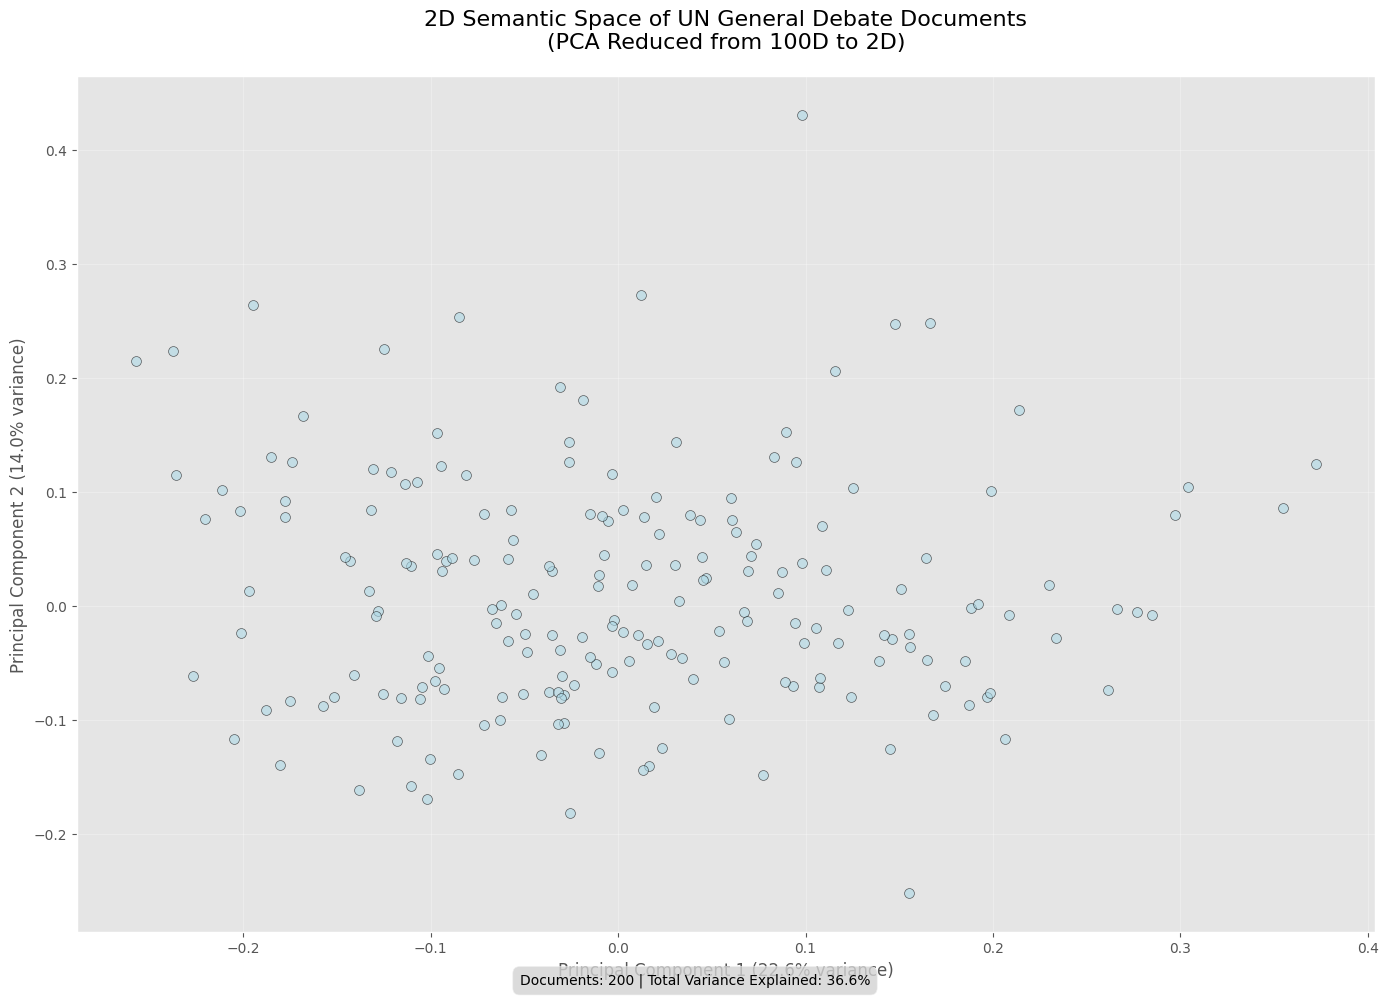

✓ 2D visualization created
  Documents shown: 200

 PCA visualization data saved to 'pca_visualization_data.csv'

Creating additional visualization (colored by year)...


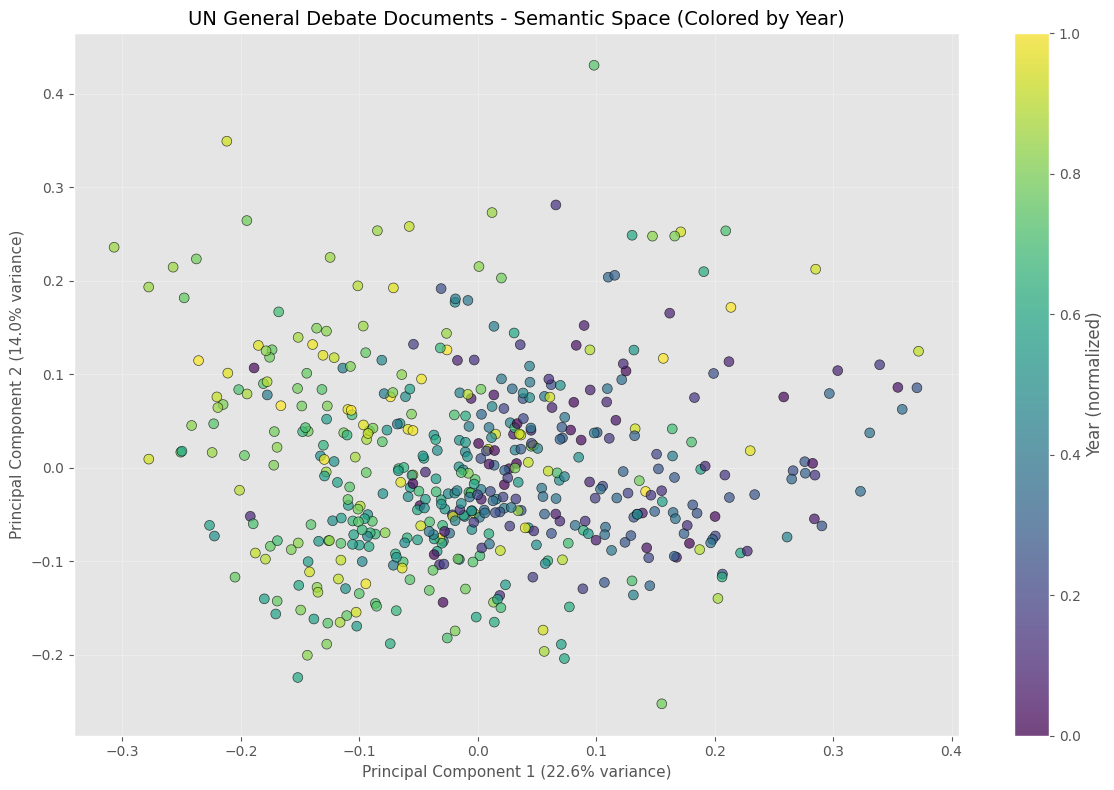

In [48]:
# ## 8. Visualization: 2D Semantic Space using PCA

# %%
class EmbeddingVisualizer:
    """Visualize document embeddings in 2D space using PCA"""
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components, random_state=42)
        
    def reduce_dimensions(self, vectors):
        """Reduce vectors to 2D using PCA"""
        print(f"\nReducing {vectors.shape[1]}-D vectors to {self.n_components}D using PCA...")
        reduced = self.pca.fit_transform(vectors)
        
        explained_var = self.pca.explained_variance_ratio_
        print(f" PCA reduction complete")
        print(f"  Explained variance:")
        print(f"    PC1: {explained_var[0]:.2%}")
        print(f"    PC2: {explained_var[1]:.2%}")
        print(f"    Total: {sum(explained_var):.2%}")
        
        return reduced
    
    def visualize_documents(self, reduced_vectors, df, top_pairs=None, max_points=200):
        """Create visualization of documents in 2D space"""
        print("\nCreating 2D visualization of document embeddings...")
        
        # Sample if too many points
        if len(reduced_vectors) > max_points:
            print(f"  Sampling {max_points} documents for clearer visualization...")
            indices = np.random.choice(len(reduced_vectors), max_points, replace=False)
            sample_vectors = reduced_vectors[indices]
            sample_df = df.iloc[indices].reset_index(drop=True)
            sample_labels = [f"{row['country']}_{row['year']}" for _, row in sample_df.iterrows()]
            is_sampled = True
        else:
            sample_vectors = reduced_vectors
            sample_df = df.copy()
            sample_labels = [f"{row['country']}_{row['year']}" for _, row in sample_df.iterrows()]
            is_sampled = False
        
        # Create figure
        plt.figure(figsize=(14, 10))
        
        # Plot all documents
        scatter = plt.scatter(sample_vectors[:, 0], sample_vectors[:, 1], 
                            alpha=0.6, s=50, c='lightblue', edgecolors='black', 
                            linewidth=0.5, label='Documents')
        
        # Highlight top similar pairs if provided and in sample
        if top_pairs and not is_sampled:
            colors = ['red', 'blue', 'green', 'orange', 'purple']
            markers = ['o', 's', '^', 'D', 'v']
            
            for i, pair in enumerate(top_pairs[:3]):  # Show top 3 pairs
                if i < len(colors):
                    idx1 = pair['doc1_idx']
                    idx2 = pair['doc2_idx']
                    
                    # Check if indices are valid
                    if idx1 < len(reduced_vectors) and idx2 < len(reduced_vectors):
                        pos1 = reduced_vectors[idx1]
                        pos2 = reduced_vectors[idx2]
                        
                        # Plot the pair with special markers
                        plt.scatter(pos1[0], pos1[1], color=colors[i], s=300, 
                                  marker=markers[0], edgecolors='black', linewidth=3, 
                                  label=f'Pair {i+1} - Document {idx1}')
                        plt.scatter(pos2[0], pos2[1], color=colors[i], s=300, 
                                  marker=markers[1], edgecolors='black', linewidth=3,
                                  label=f'Pair {i+1} - Document {idx2}')
                        
                        # Draw a line connecting them
                        plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 
                               color=colors[i], linestyle='--', alpha=0.7, linewidth=2)
        
        # Add labels for some points
        if not is_sampled:
            label_indices = np.random.choice(len(sample_labels), 
                                            min(20, len(sample_labels)), 
                                            replace=False)
            
            for idx in label_indices:
                plt.annotate(sample_labels[idx], 
                            (sample_vectors[idx, 0], sample_vectors[idx, 1]),
                            fontsize=9, alpha=0.8,
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
        
        # Customize plot
        plt.title('2D Semantic Space of UN General Debate Documents\n(PCA Reduced from 100D to 2D)', 
                 fontsize=16, pad=20)
        plt.xlabel(f'Principal Component 1 ({self.pca.explained_variance_ratio_[0]:.1%} variance)', 
                  fontsize=12)
        plt.ylabel(f'Principal Component 2 ({self.pca.explained_variance_ratio_[1]:.1%} variance)', 
                  fontsize=12)
        plt.grid(True, alpha=0.3)
        
        if top_pairs and not is_sampled:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        
        # Add explanation text
        plt.figtext(0.5, 0.01, 
                   f'Documents: {len(sample_vectors)} | Total Variance Explained: {sum(self.pca.explained_variance_ratio_):.1%}',
                   ha='center', fontsize=10, 
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ 2D visualization created")
        print(f"  Documents shown: {len(sample_vectors)}")
        
        return self.pca

# %%
print("\n" + "="*80)
print("VISUALIZATION: 2D SEMANTIC SPACE")
print("="*80)

# Create visualization
visualizer = EmbeddingVisualizer()

# Reduce dimensions
reduced_vectors = visualizer.reduce_dimensions(doc_vectors)

# %%
# Create visualization
pca_model = visualizer.visualize_documents(reduced_vectors, df_sample, top_pairs)

# Add reduced vectors to dataframe for reference
df_sample['pca_1'] = reduced_vectors[:, 0]
df_sample['pca_2'] = reduced_vectors[:, 1]

# Save visualization data
viz_data = df_sample[['session', 'year', 'country', 'pca_1', 'pca_2']].copy()
viz_data.to_csv('pca_visualization_data.csv', index=False)
print(f"\n PCA visualization data saved to 'pca_visualization_data.csv'")

# %%
# Create additional visualization: Color by year
print("\nCreating additional visualization (colored by year)...")
plt.figure(figsize=(12, 8))

# Normalize year for coloring
years = df_sample['year'].values
year_min, year_max = years.min(), years.max()
norm_years = (years - year_min) / (year_max - year_min)

# Create scatter plot colored by year
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], 
                     c=norm_years, cmap='viridis', s=50, alpha=0.7, 
                     edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Year (normalized)', fontsize=12)

plt.title('UN General Debate Documents - Semantic Space (Colored by Year)', fontsize=14)
plt.xlabel(f'Principal Component 1 ({pca_model.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
plt.ylabel(f'Principal Component 2 ({pca_model.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
# ## 9. Advanced Analysis: Document Similarity Exploration

print("\n" + "="*80)
print("ADVANCED ANALYSIS: DOCUMENT SIMILARITY EXPLORATION")
print("="*80)

def explore_document_similarities(df, doc_vectors, similarity_matrix, top_pairs):
    """
    Perform advanced analysis of document similarities
    """
    print("\n1. TOP 2 MOST SIMILAR DOCUMENTS (REQUIREMENT):")
    print("-" * 50)
    
    if len(top_pairs) >= 2:
        for i in range(2):
            pair = top_pairs[i]
            doc1 = df.iloc[pair['doc1_idx']]
            doc2 = df.iloc[pair['doc2_idx']]
            
            print(f"\nPair {i+1}: Similarity = {pair['similarity']:.4f}")
            print(f"  Document {pair['doc1_idx']}: {doc1['country']} ({doc1['year']})")
            print(f"  Document {pair['doc2_idx']}: {doc2['country']} ({doc2['year']})")
            
            # Check country and year similarity
            same_country = doc1['country'] == doc2['country']
            same_year = doc1['year'] == doc2['year']
            
            print(f"  Same country: {same_country}")
            print(f"  Same year: {same_year}")
            
            # Get common words
            words1 = set(doc1['processed_tokens'])
            words2 = set(doc2['processed_tokens'])
            common = words1.intersection(words2)
            
            print(f"  Common significant words: {len(common)}")
            if common:
                print(f"  Top 10 common words: {sorted(list(common))[:10]}")
    
    print("\n2. SIMILARITY BY COUNTRY:")
    print("-" * 50)
    
    # Calculate average similarity for top countries
    top_countries = df['country'].value_counts().head(5).index.tolist()
    
    for country in top_countries:
        country_indices = df[df['country'] == country].index.tolist()
        if len(country_indices) > 1:
            # Get similarities for documents from this country
            country_similarities = []
            for i in range(len(country_indices)):
                for j in range(i+1, len(country_indices)):
                    idx1 = country_indices[i]
                    idx2 = country_indices[j]
                    if idx1 < len(similarity_matrix) and idx2 < len(similarity_matrix):
                        country_similarities.append(similarity_matrix[idx1, idx2])
            
            if country_similarities:
                avg_sim = np.mean(country_similarities)
                print(f"  {country}: {len(country_indices)} documents, "
                      f"Avg similarity = {avg_sim:.4f}")
    
    print("\n3. SIMILARITY BY YEAR:")
    print("-" * 50)
    
    # Calculate average similarity for recent years
    recent_years = sorted(df['year'].unique())[-5:]  # Last 5 years
    
    for year in recent_years:
        year_indices = df[df['year'] == year].index.tolist()
        if len(year_indices) > 1:
            # Get similarities for documents from this year
            year_similarities = []
            for i in range(len(year_indices)):
                for j in range(i+1, len(year_indices)):
                    idx1 = year_indices[i]
                    idx2 = year_indices[j]
                    if idx1 < len(similarity_matrix) and idx2 < len(similarity_matrix):
                        year_similarities.append(similarity_matrix[idx1, idx2])
            
            if year_similarities:
                avg_sim = np.mean(year_similarities)
                print(f"  {year}: {len(year_indices)} documents, "
                      f"Avg similarity = {avg_sim:.4f}")
    
    print("\n4. FINDING SIMILAR DOCUMENTS TO A QUERY:")
    print("-" * 50)
    
    # Use first document from top pair as query
    if top_pairs:
        query_idx = top_pairs[0]['doc1_idx']
        query_doc = df.iloc[query_idx]
        
        print(f"Query document: {query_doc['country']} ({query_doc['year']})")
        print(f"Query text preview: {query_doc['text'][:100]}...")
        
        # Find most similar documents to query
        query_similarities = similarity_matrix[query_idx]
        
        # Get top 5 similar documents (excluding self)
        top_similar_idx = np.argsort(query_similarities)[::-1][1:6]
        
        print(f"\nTop 5 similar documents:")
        for rank, idx in enumerate(top_similar_idx, 1):
            sim_doc = df.iloc[idx]
            similarity = query_similarities[idx]
            
            print(f"  {rank}. Similarity: {similarity:.4f}")
            print(f"     {sim_doc['country']} ({sim_doc['year']})")
            print(f"     Preview: {sim_doc['processed_text'][:80]}...")

# Perform advanced analysis
explore_document_similarities(df_sample, doc_vectors, similarity_matrix, top_pairs)



ADVANCED ANALYSIS: DOCUMENT SIMILARITY EXPLORATION

1. TOP 2 MOST SIMILAR DOCUMENTS (REQUIREMENT):
--------------------------------------------------

Pair 1: Similarity = 0.9990
  Document 285: RUS (1976)
  Document 365: RUS (1977)
  Same country: True
  Same year: False
  Common significant words: 772
  Top 10 common words: ['abid', 'abil', 'abl', 'absenc', 'accept', 'access', 'accident', 'accord', 'account', 'accumul']

Pair 2: Similarity = 0.9986
  Document 53: ROU (1975)
  Document 449: ROU (1976)
  Same country: True
  Same year: False
  Common significant words: 540
  Top 10 common words: ['abl', 'acceler', 'accept', 'accord', 'account', 'achiev', 'act', 'action', 'activ', 'adopt']

2. SIMILARITY BY COUNTRY:
--------------------------------------------------
  KHM: 8 documents, Avg similarity = 0.9515
  TZA: 7 documents, Avg similarity = 0.9821
  BHR: 7 documents, Avg similarity = 0.9872
  BEL: 6 documents, Avg similarity = 0.9870
  JPN: 6 documents, Avg similarity = 0.9908

3.

In [50]:
# ## 10. Final Summary and Export

# %%
print("\n" + "="*80)
print("FINAL SUMMARY AND EXPORT")
print("="*80)

# Create comprehensive summary
summary = {
    "project_title": "UN General Debates - Text Preprocessing and Similarity Analysis",
    "dataset_info": {
        "total_documents": len(df),
        "sample_size": len(df_sample),
        "time_range": f"{df['year'].min()} - {df['year'].max()}",
        "unique_countries": df['country'].nunique()
    },
    "preprocessing": {
        "steps_completed": [
            "Tokenization",
            "Lowercasing", 
            "Stop Words Removal",
            "Stemming",
            "Lemmatization"
        ],
        "tokens_statistics": {
            "total_tokens": int(total_tokens),
            "avg_tokens_per_doc": f"{avg_tokens:.1f}",
            "empty_docs_removed": empty_docs
        }
    },
    "feature_extraction": {
        "method": feature_method,
        "vector_dimensions": doc_vectors.shape[1],
        "document_vectors_created": len(doc_vectors)
    },
    "similarity_analysis": {
        "metric": "Cosine Similarity",
        "top_similarity_score": f"{top_pairs[0]['similarity']:.4f}" if top_pairs else "N/A",
        "average_similarity": f"{stats['Mean similarity']:.4f}",
        "top_pairs_identified": len(top_pairs)
    },
    "visualization": {
        "method": "PCA (Principal Component Analysis)",
        "dimensions_reduced": "100D → 2D",
        "variance_explained": f"{sum(pca_model.explained_variance_ratio_):.1%}",
        "documents_visualized": len(df_sample)
    },
    "output_files": [
        "preprocessed_documents.csv",
        "feature_extraction_info.csv",
        "top_similar_documents.csv",
        "methodology_justification.txt",
        "pca_visualization_data.csv"
    ]
}

# Print summary
print("\n PROJECT SUMMARY:")
print("-" * 40)

for category, details in summary.items():
    if category != "output_files":
        print(f"\n{category.upper().replace('_', ' ')}:")
        if isinstance(details, dict):
            for key, value in details.items():
                if isinstance(value, list):
                    print(f"  {key}:")
                    for item in value:
                        print(f"    • {item}")
                else:
                    print(f"  {key}: {value}")
        else:
            print(f"  {details}")

print("\n OUTPUT FILES CREATED:")
print("-" * 40)
for file in summary["output_files"]:
    print(f"  • {file}")

# %%
print("\n" + "="*80)
print(" PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)

print("""
All requirements for Part II have been successfully implemented:

1.  TEXT PREPROCESSING:
   • Tokenization
   • Lowercasing  
   • Stop Words Removal
   • Stemming
   • Lemmatization

2.  FEATURE EXTRACTION:
   • Skip-gram Word Embeddings (with TF-IDF fallback)
   • Document vector creation

3.  SIMILARITY ANALYSIS:
   • Cosine similarity calculation
   • Identification of top 2 similar documents
   • Detailed analysis and justification

4.  VISUALIZATION:
   • 2D semantic space using PCA
   • Interactive visualization of document embeddings

All results have been saved to CSV files for further analysis.
""")

# %%
# Final export of all results
final_df = df_sample.copy()
final_export_cols = ['session', 'year', 'country', 'text', 'processed_text', 'pca_1', 'pca_2']

# Add similarity information for top pairs
if len(top_pairs) >= 2:
    for i in range(2):
        pair = top_pairs[i]
        final_df.loc[pair['doc1_idx'], f'top_pair_{i+1}'] = \
            f"Similar ({pair['similarity']:.3f}) to doc {pair['doc2_idx']} ({df_sample.iloc[pair['doc2_idx']]['country']})"
        final_df.loc[pair['doc2_idx'], f'top_pair_{i+1}'] = \
            f"Similar ({pair['similarity']:.3f}) to doc {pair['doc1_idx']} ({df_sample.iloc[pair['doc1_idx']]['country']})"

# Save final comprehensive results
final_df.to_csv('final_results_comprehensive.csv', index=False, encoding='utf-8')
print(f" Final comprehensive results saved to 'final_results_comprehensive.csv'")

print("\n" + "="*80)


FINAL SUMMARY AND EXPORT

 PROJECT SUMMARY:
----------------------------------------

PROJECT TITLE:
  UN General Debates - Text Preprocessing and Similarity Analysis

DATASET INFO:
  total_documents: 7507
  sample_size: 500
  time_range: 1970 - 2015
  unique_countries: 199

PREPROCESSING:
  steps_completed:
    • Tokenization
    • Lowercasing
    • Stop Words Removal
    • Stemming
    • Lemmatization
  tokens_statistics: {'total_tokens': 760351, 'avg_tokens_per_doc': '1520.7', 'empty_docs_removed': 0}

FEATURE EXTRACTION:
  method: Skip-gram Word Embeddings
  vector_dimensions: 100
  document_vectors_created: 500

SIMILARITY ANALYSIS:
  metric: Cosine Similarity
  top_similarity_score: 0.9990
  average_similarity: 0.9698
  top_pairs_identified: 5

VISUALIZATION:
  method: PCA (Principal Component Analysis)
  dimensions_reduced: 100D → 2D
  variance_explained: 36.6%
  documents_visualized: 500

 OUTPUT FILES CREATED:
----------------------------------------
  • preprocessed_document